# Best Practices - PyTorch FCN ResNet50 on COCO


## Optimizing FCN ResNet50 with NetsPresso Model Compressor
By following this notebook, the user can get FCN ResNet50 which has 1.37x low latency, 1.39x fewer parameters only with 0.1 mIoU drop by using NetsPresso Model Compressor.


This notebook contains the following 3 parts:
  1. [Model Compression with NetsPresso Model Compressor](#1.-Model-Compression-with-NetsPresso-Model-Compressor)
  2. [Fine-Tuning the Compressed Model](#2.-Fine-tuning-the-Compressed-Model)
  3. [Compression-Results](#3.-Compression-Results)
  
For more details about NetsPresso Model Compressor, please visit [Docs](https://docs.netspresso.ai/docs/technology-support-1) and [Netspresso.ai](https://www.netspresso.ai).


<div align="center">
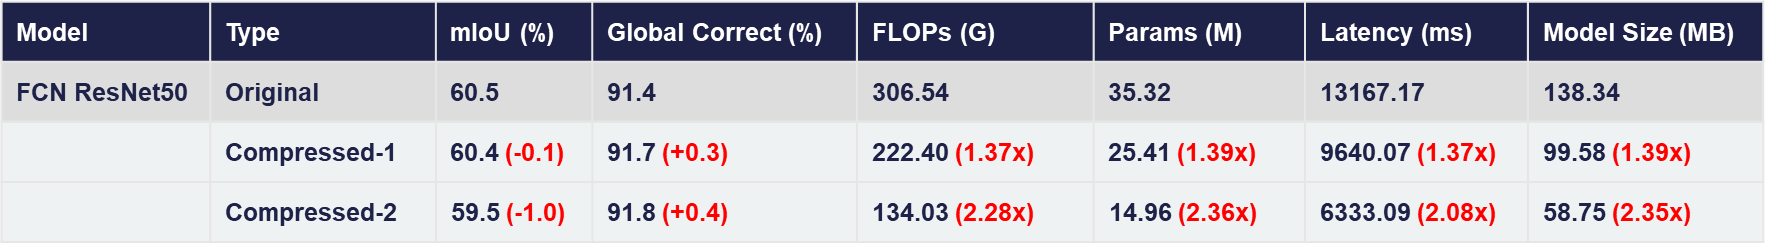
</div>
<div align='center'>
Fig. 1 Compression results of the FCN ResNet50. The model's latency is measured using a Raspberry Pi 4B (1.5GHz ARM Cortex). We set the model's data type to FP32, and an inference engine to ONNX Runtime to measure the latency.
</div>

<a name="1.-Model-Compression-with-NetsPresso-Model-Compressor"></a>
# 1. Model Compression with NetsPresso Model Compressor

### Setting up your environment


Downloading the pre-trained model.

Cloning the FCN ResNet50 code ([link](https://github.com/pytorch/vision))

In [ ]:
! git clone https://github.com/pytorch/vision.git
os.chdir('./vision')

Installing the following packages:

In [ ]:
# You MUST install the compatible torch version with your cuda version. Here, we set PyTorch 1.12.0 with CUDA 11.3 as default. (Support: PyTorch version >= 1.10) 
! pip install torch==1.12.0+cu113 torchvision==0.13.0+cu113 torchaudio==0.12.0 --extra-index-url https://download.pytorch.org/whl/cu113  
! python setup.py install
! pip install pycocotools
! pip install thop
! pip install onnx
! pip install onnxruntime
! pip install torchsummary

### Preparing the pre-trained FCN ResNet50 on COCO 

In [ ]:
import torchvision
original_model = model = torchvision.models.segmentation.fcn_resnet50(weights="FCN_ResNet50_Weights.DEFAULT", aux_loss=True)

### **FCN ResNet50 compression using NetsPresso Model Compressor**

<a name='compGuide'></a>

__Compression Guide__ 
1. Sign up for NetsPresso Model Compressor ([link](https://compression.netspresso.ai/#/login)).
2. Upload the original FCN ResNet50. The model should be converted into the `GraphModule (torch.fx.GraphModule)` format. Please check the below [code block](#Conversion-into-GraphModule-Format) to convert the model.
3. To reproduce the best practice result, please select the following compression procedures one by one as depicted [here](#2.-Fine-tuning-the-Compressed-Model): 
    * For the first case of Fig. 1,
        * `L2 Norm Pruning` &rarr; `Recommendation(SLAMP) pruning ratio: 0.1`
    * For the second case,
        * `L2 Norm Pruning` &rarr; `Recommendation(SLAMP) pruning ratio: 0.4`
        * Please change `add15 layer's pruning ratio` as `0.8`.
        
4. Press `Compress` button, and get the compressed model. The compression result will be shown as follow.

<!-- ---
* If it is hard to follow, please refer to the following user-guide video ([link](https://www.youtube.com/watch?v=MqTI212VQi0)). -->

<div align='center'>
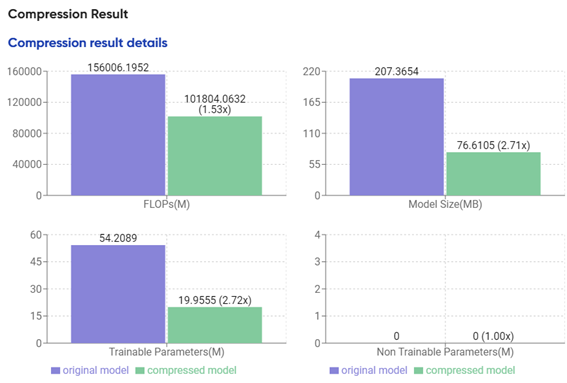
&nbsp; &nbsp; &nbsp; &nbsp;
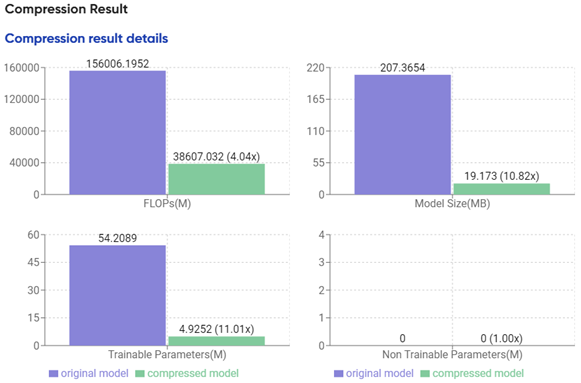
</div>
<div align='center'>
Fig 2. The results of each compression. Left: L2 Norm Pruning (0.4). Right: L2 Norm Pruning (0.7).
</div>
수정 필요

<a name="Conversion-into-GraphModule-Format"></a>
### Conversion into GraphModule format

In [ ]:
import torch
import torch.fx
import torchvision
original_model = torchvision.models.segmentation.fcn_resnet50(weights="FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1", aux_loss=True)

graph = torch.fx.Tracer().trace(original_model)
traced_model = torch.fx.GraphModule(original_model, graph)
torch.save(traced_model, '../FCN_ResNet50_original.pt')

<a name="2.-Fine-tuning-the-Compressed-Model"></a>
# 2. Fine-tuning the Compressed Model
Structured pruning may induce the performance degradation, which requires additional fine-tuning process.  
Therefore, the fine-tuning process is necessary to compensate the performance after each compression process.  
Here, `Structured Pruning` &rarr; `Fine-tuning`

<a name='#fine-tuning'></a>
### Fine-tuning the compressed model

To fine-tune the compressed model, we need to change some codes in `train.py`. You can get the changed training code `train_compressed.py` by running the following code block. You can see the details of the modifications at [Appendix](#Appendix).

In [ ]:
! cd ./references/segmentation && \
wget https://raw.githubusercontent.com/yjlee0607/yolox_files/main/train_compressed.py

If you already have COCO dataset, then just skip the following code block.

In [ ]:
# Download COCO dataset
! wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/hierarchy_change/scripts/coco.sh
! sh coco.sh

Fine-tuning the compressed model

In this Notebook, we fine-tune ([link](#2.-Fine-tuning-the-Compressed-Model)) and verify ([link](#3.-Compression-Results)) the model for the first case of Fig. 1 by default.  
* `FCN_ResNet50_compressed_model_L2Norm_01.pt` means the model compressed by `L2 Norm pruning (pruning ratio: 0.1)`. 
* Please upload the compressed model to the same directory with `FCN_ResNet50_original.pt`.

You must modify the following flags: `--data-path=/path/to/your/coco/dataset` & `--nproc_per_node=<number_of_gpus_avaiable>`

In [ ]:
! torchrun --nproc_per_node=4 ./references/segmentation/train_compressed.py \
--pt_model ../FCN_ResNet50_compressed_model_L2Norm_01.pt \
--data-path /path/to/your/coco/dataset \
--dataset coco \
--aux-loss \
-b 4 \
--epochs 30 \
--lr 0.002 \
--device cuda \
--output-dir ./output



<a name="3.-Compression-Results"></a>
# 3. Compression Results

In this section, we visualize and verify the effectiveness of the NetsPresso Model Compressor on FCN ResNet50.

* [Visualizing the optimization process](#Visualizing-the-optimization-process-on-FCN-ResNet50)
* [Accuracy](#Accuracy-comparision)
* [FLOPs and parameters](#FLOPs-&-Parameters-comparision)
* [Latency](#Latency-comparision)
* [Architecture of the compressed model](#Architecture-of-the-compressed-model)

<a name='Visualizing-the-optimization-process-on-FCN-ResNet50'></a>

<!-- ### Visualization of How NetsPresso Model Compressor Optimizes MobileNetV1 -->
### Visualizing the optimization process on FCN ResNet50

Fig.3 visualizes part of the original, decomposed and pruned FCN ResNet50.
Here, we applied [L2 Norm Pruning](https://docs.netspresso.ai/docs/pruning#structured-pruning) to optimize the model.
<div align="center">

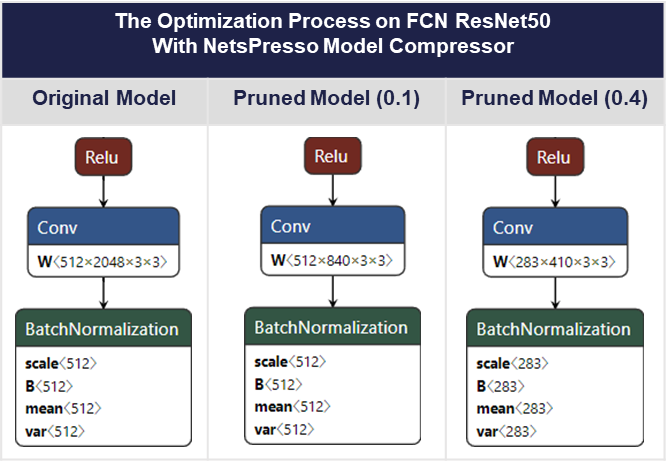
</div>
<div align='center'>Fig. 3 The optimization process for a single convolutional neural network in FCN ResNet50 with NetsPresso Model Compressor</div>

<a name="Accuracy-comparision"></a>
### Accuracy comparision

Evaluation code for the original model

In [ ]:
! CUDA_VISIBLE_DEVICES=0 torchrun --nproc_per_node=1 ./references/segmentation/train_compressed.py \
--pt_model ../FCN_ResNet50_original.pt \
--data-path /root/workspace/datasets/COCO \
--dataset coco \
--aux-loss \
-b 1 \
--device cuda \
--test-only

Evaluation code for the compressed model

In [ ]:
! CUDA_VISIBLE_DEVICES=0 torchrun --nproc_per_node=1 ./references/segmentation/train_compressed.py \
--pt_model ../FCN_ResNet50_compressed_model_L2Norm_01.pt \
--data-path /root/workspace/datasets/COCO \
--dataset coco \
--aux-loss \
-b 1 \
--device cuda \
--test-only

<a name="FLOPs-&-Parameters-comparision"></a>
### FLOPs & Parameters comparision

In [ ]:
from thop import profile

device = 'cuda' if torch.cuda.is_available() else 'cpu'

original_model = torch.load('../FCN_ResNet50_original.pt', map_location='cpu').to(device)
compressed_model = torch.load('../FCN_ResNet50_compressed_model_L2Norm_01.pt', map_location='cpu').to(device)

dummy_input = torch.ones((1,3,520,520)).to(device)

original_macs, original_params = profile(original_model, inputs=(dummy_input, ))
compressed_macs, compressed_params = profile(compressed_model, inputs=(dummy_input, ))

print("\n--- Original model ==> Compressed model ---")
print(f"FLOPs: {original_macs*2} ==> {compressed_macs*2} (x{round(original_macs/compressed_macs,3)})")
print(f"Params: {original_params} ==> {compressed_params} (x{round(original_params/compressed_params,3)})")

### Latency comparision

In [ ]:
import onnx
def onnxExport(model, model_name, device = torch.device('cpu')):
    model = model.to(device.type)
    dummy_input = torch.ones((1,3,520,520)).to(device.type)
    torch.onnx.export(model,dummy_input,model_name,verbose=False)

original_model = torch.load('../FCN_ResNet50_original.pt', map_location='cpu')
compressed_model = torch.load('../FCN_ResNet50_compressed_model_L2Norm_01.pt', map_location='cpu')

onnxExport(original_model, '../FCN_ResNet50_original.onnx')
onnxExport(compressed_model, '../FCN_ResNet50_compressed_model_L2Norm_01.onnx')

In [ ]:
import onnxruntime
import numpy as np

def inference_time(model_path,run_times):
    device = torch.device('cpu')
    img_size = 520
    so = onnxruntime.SessionOptions()
    so.execution_mode = onnxruntime.ExecutionMode.ORT_SEQUENTIAL
    so.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_EXTENDED
    exproviders = [ 'CPUExecutionProvider']
    ort_session = onnxruntime.InferenceSession(model_path, so, providers=exproviders)

    input_names = ort_session.get_inputs()[0].name
    output_names = ort_session.get_outputs()[0].name
    # warm up
    dummy_input = np.random.rand(1,3,img_size,img_size).astype(np.float32)
    for _ in range(10):
        #IOBinding
        data = onnxruntime.OrtValue.ortvalue_from_numpy(dummy_input, device.type, 0)
        io_binding = ort_session.io_binding()
        io_binding.bind_input(input_names, device.type, 0, np.float32, [1, 3, img_size, img_size], data.data_ptr())
        io_binding.bind_output(output_names, device.type)

        torch.cuda.synchronize()
        with torch.no_grad():
            ort_session.run_with_iobinding(io_binding)
        torch.cuda.synchronize()

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    latency = []
    for _ in range(run_times):
        dummy_input = np.random.rand(1,3,img_size,img_size).astype(np.float32)
        #IOBinding
        data = onnxruntime.OrtValue.ortvalue_from_numpy(dummy_input, device.type, 0)
        io_binding.bind_input(input_names, device.type, 0, np.float32, [1, 3, img_size, img_size], data.data_ptr())
        io_binding.bind_output(output_names, device.type)

        torch.cuda.synchronize()
        start.record() 
        with torch.no_grad():
            ort_session.run_with_iobinding(io_binding)
        end.record()
        torch.cuda.synchronize()
        time_elapsed = start.elapsed_time(end)
        latency.append(time_elapsed)
    return sum(latency)/len(latency)


original_latency = inference_time('../FCN_ResNet50_original.onnx',run_times=10)
compressed_latency = inference_time('../FCN_ResNet50_compressed_model_L2Norm_01.onnx',run_times=10)

print("Original Model ==> Compressed Model")
print(f"Latency: {round(original_latency,3)}ms ==> {round(compressed_latency,3)}ms (x{round(original_latency/compressed_latency,3)})")

In [ ]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

summary(compressed_model.to(device),(3,520,520),device=device)

<a name="Appendix"></a>
# Appendix
In this section, we go into detail about the code we've changed for fine-tuning.

1. We define `PolynomialLR` because it is only supported in the nightly version of torch today (November 11th, 2022) [(link)](https://github.com/pytorch/vision/compare/main...yjlee0607:vision:main#diff-30e164970223cb9837a01952dbd9e235676c06e40f88b5a4388bacc1b8b8e8d5L13).  You can check the source code [here](https://github.com/pytorch/pytorch/blob/nightly/torch/optim/lr_scheduler.py#L717).
2. The model's attributes are likely to be changed when we convert the model into a `GraphModule` format. Here, we change how to access the `GraphModule` model's parameters.[(link)](https://github.com/pytorch/vision/commit/7f3039bb4f58f84d83689a49c79c275295060d41#diff-30e164970223cb9837a01952dbd9e235676c06e40f88b5a4388bacc1b8b8e8d5L225). 